In [1]:
import ParseTimeTrials

FilePath = "TimeTrials.txt"
Parser = ParseTimeTrials.ParserClass()
Parser.AddFiles(FilePath)
Parser.Main()

I got this path TimeTrials.txt


Now that the input file is parsed and put into containers, get ready to plot. 
For your information, the size of the dataset is 20,000 rows x 15,000 columns. This 20,000 is a nice number because that is the number of genes in the human genome. Therefore a comparison of gene expression data will typically be about this many rows. The computational complexity of each similarity algorithm grows with the number of rows, where as the number of comparisions done in the BSF is simply N^2 / 2. So for this comparison there are 112 million comparisons for the 'up regulated' matrix and 112 million comparisons for the 'down regulated' matrix. Making in total about 225 million comparisons.

Some example output simply to look at.

In [2]:
#print out the keys for the bakeoff
print (Parser.SeriesData.keys())
Method = "original popcount"
## if you want to see the raw data, uncomment below
#Parser.SeriesData[Method].AllData
#Parser.SeriesData[Method].AverageTime
#Parser.SeriesData[Method].StdevTime


dict_keys(['euclidean', 'adjusted popcount', 'original popcount', 'cosine', 'tanimoto'])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from scipy import stats

[-86.94699564  30.69810369]
[  1.14491521e+01   1.94141642e-03]


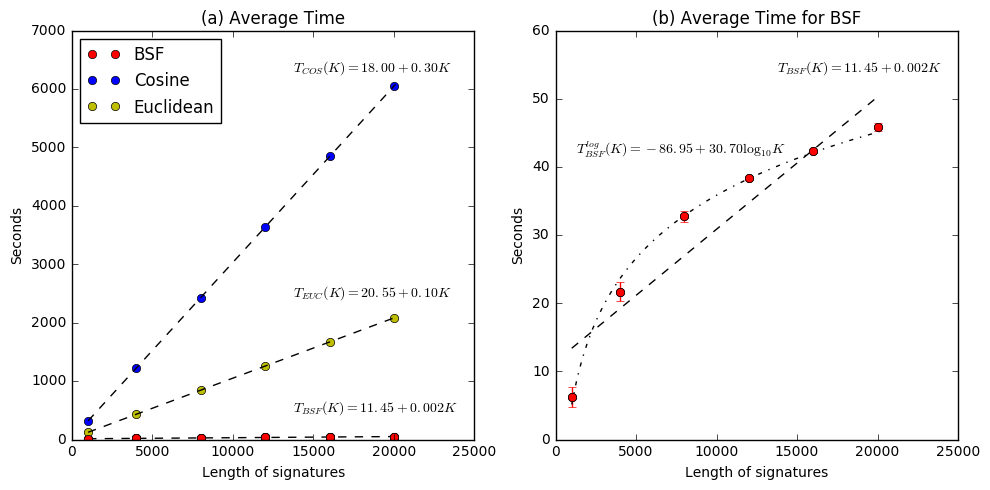

11.4580866242


In [10]:
#BitLengths = number of bits in a signature. called 'bl' for short
bl = np.array(list(Parser.SeriesData["cosine"].AverageTime.keys()), dtype='float')
cosine_observedtimes = np.array(list(Parser.SeriesData["cosine"].AverageTime.values()), dtype='float')
euclidean_observedtimes = np.array(list(Parser.SeriesData["euclidean"].AverageTime.values()), dtype='float')
bsf_observedtimes = np.array(list(Parser.SeriesData["original popcount"].AverageTime.values()), dtype='float')
bl = np.sort(bl)
cosine_observedtimes = np.sort(cosine_observedtimes)
euclidean_observedtimes = np.sort(euclidean_observedtimes)
bsf_observedtimes = np.sort(bsf_observedtimes)

#now make fit functions, like in an example that I found online
#(http://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy)
#all functions have the same bit length, so they all use 'bl' as the x coordinate
x_new = np.linspace(bl[0], bl[-1]+100, num=len(bl)*10)
cosine_coefs = poly.polyfit(bl, cosine_observedtimes, 1)
cosine_ffit = poly.polyval(x_new, cosine_coefs)
euclidean_coefs = poly.polyfit(bl, euclidean_observedtimes, 1)
euclidean_ffit = poly.polyval(x_new, euclidean_coefs)
# fit to y = a + b logx
bsf_coefs_log = poly.polyfit(np.log10(bl), bsf_observedtimes, 1)
bsf_ffit = poly.polyval(np.log10(x_new), bsf_coefs_log)
print(bsf_coefs_log)
bsf_coefs = poly.polyfit(bl, bsf_observedtimes, 1)
print(bsf_coefs)

# calculate 95% confidence interval for the mean of N draws
def get_CI(mu, sigma, prob=0.90, num = 1):
    _min, _max = stats.norm.interval(prob, loc=mu, scale=sigma/np.sqrt(num))
    return [mu-_min, _max-mu]

def fit_bsf_fx(length):
    return poly.polyval(np.log10(length), bsf_coefs)

cosine_err = []
euclidean_err = []
bsf_err = []

for time in bl:
    cosine_err.append(get_CI(Parser.SeriesData["cosine"].AverageTime[time], Parser.SeriesData["cosine"].StdevTime[time]))
    euclidean_err.append(get_CI(Parser.SeriesData["euclidean"].AverageTime[time], Parser.SeriesData["euclidean"].StdevTime[time]))
    bsf_err.append(get_CI(Parser.SeriesData["original popcount"].AverageTime[time], Parser.SeriesData["original popcount"].StdevTime[time]))

#show the fit function, just for fun
plt.close('all')
plt.figure(figsize=(10,5))

eq = r"$T_{BSF}^{log}{(K)}="+('%0.2f' % bsf_coefs_log[0]) +'+' + ('%0.2f' % bsf_coefs_log[1]) + "\log_{10}{K}$"
eq_b = r"$T_{BSF}{(K)}="+('%0.2f' % bsf_coefs[0]) +'+' + ('%0.3f' % bsf_coefs[1]) + "K$"
eq_e = r"$T_{EUC}{(K)}="+('%0.2f' % euclidean_coefs[0]) +'+' + ('%0.2f' % euclidean_coefs[1]) + "K$"
eq_c = r"$T_{COS}{(K)}="+('%0.2f' % cosine_coefs[0]) +'+' + ('%0.2f' % cosine_coefs[1]) + "K$"

ax = plt.subplot(121)
ax.text(0.55, 0.9, eq_c, transform=ax.transAxes, size=10, weight='bold')
ax.text(0.55, 0.35, eq_e, transform=ax.transAxes, size=10, weight='bold')
ax.text(0.55, 0.07, eq_b, transform=ax.transAxes, size=10, weight='bold')
plt.plot(bl, bsf_observedtimes, 'ro', label='BSF')
plt.plot(x_new, poly.polyval(x_new, bsf_coefs), '--k')
plt.errorbar(bl, bsf_observedtimes, yerr=np.array(bsf_err).transpose(), fmt='ro')
plt.plot(bl, cosine_observedtimes, 'bo', label='Cosine')
plt.errorbar(bl, bsf_observedtimes, yerr=np.array(cosine_err).transpose(), fmt='ro')
plt.plot(x_new, cosine_ffit, '--k')
plt.plot(bl, euclidean_observedtimes, 'yo', label='Euclidean')
plt.errorbar(bl, bsf_observedtimes, yerr=np.array(euclidean_err).transpose(), fmt='ro')
plt.plot(x_new, euclidean_ffit, '--k')
plt.title('(a) Average Time')
plt.ylabel('Seconds')
plt.xlabel('Length of signatures')
plt.legend(loc=0)

# log-scale of above
# ax = plt.subplot(222)
# plt.semilogy(bl, bsf_observedtimes, 'ro', label='BSF')
# plt.errorbar(bl, bsf_observedtimes, yerr=np.array(bsf_err).transpose(), fmt='ro')
# plt.semilogy(x_new, poly.polyval(x_new, bsf_coefs), '--k')
# plt.semilogy(bl, cosine_observedtimes, 'bo', label='Cosine')
# plt.errorbar(bl, bsf_observedtimes, yerr=np.array(cosine_err).transpose(), fmt='ro')
# plt.semilogy(x_new, cosine_ffit, '--k')
# plt.semilogy(bl, euclidean_observedtimes, 'yo', label='Euclidean')
# plt.errorbar(bl, bsf_observedtimes, yerr=np.array(euclidean_err).transpose(), fmt='ro')
# plt.semilogy(x_new, euclidean_ffit, '--k')
# plt.title('(b) Average Time (log scale)')
# plt.ylabel('Seconds')
# plt.legend(loc=0)

ax = plt.subplot(122)
ax.text(0.55, 0.9, eq_b, transform=ax.transAxes, size=10, weight='bold')
ax.text(0.05, 0.7, eq, transform=ax.transAxes, size=10)
plt.plot(bl, bsf_observedtimes, 'ro', x_new, bsf_ffit, '-.k')
plt.plot(x_new, poly.polyval(x_new, bsf_coefs), '--k')
plt.errorbar(bl, bsf_observedtimes, yerr=np.array(bsf_err).transpose(), fmt='ro', label='BSF')
plt.title('(b) Average Time for BSF')
plt.ylabel('Seconds')
plt.xlabel('Length of signatures')

# log-scale of above
# ax = plt.subplot(224)
# plt.semilogy(bl, bsf_observedtimes, 'ro', x_new, bsf_ffit, '-.k')
# plt.errorbar(bl, bsf_observedtimes, yerr=np.array(bsf_err).transpose(), fmt='ro')
# plt.title('(d) Average Time for BSF (log scale)')
# plt.ylabel('Seconds')

plt.tight_layout()
plt.savefig('fig_time_trials.png')
plt.show()

#Now let's ask my program how long this will take for some obsenely long bit signature, like 40,000
time_bsf_40k = fit_bsf_fx(40000)
print (time_bsf_40k)


In [5]:
bsf_coefs

sec = (117373*117372) * (cosine_coefs[1]*22688 + cosine_coefs[0])/(15000*14999/2)
0.988*sec/(3600*24)

9.6070317226842228

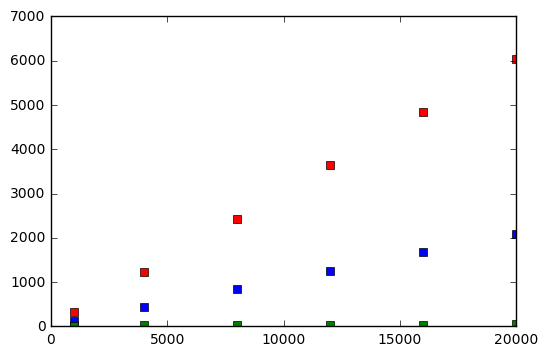

In [6]:
plt.plot(bl, cosine_observedtimes, 'rs', bl, euclidean_observedtimes, 'bs', bl, bsf_observedtimes, 'gs') #inexplicably 'rs' means red square
plt.show()